**📄 Invoice Information Extraction Notebook**

This notebook demonstrates how to extract **invoice number, date, and line items** from invoice images using:
- HuggingFace invoice dataset (`katanaml-org/invoices-donut-data-v1`)
- OCR with Tesseract
- Regex-based extraction
- Optional HuggingFace Donut model

---

In [ ]:
!pip install datasets pytesseract pillow pdf2image matplotlib
!apt-get install -y tesseract-ocr

!pip install transformers accelerate timm sentencepiece


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
'apt-get' is not recognized as an internal or external command,
operable program or batch file.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


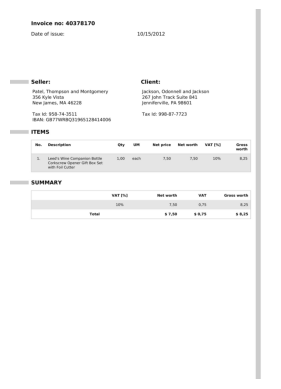

Invoice no: 40378170

Date of issue:

Seller:

Patel, Thompson and Montgomery
356 Kyle Vista
New James, MA 46228

Tax Id: 958-74-3511
IBAN: GB77WRBQ31965128414006

ITEMS
No. Description Qty
1. Leed's Wine Companion Bottle 1,00

Corkscrew Opener Gift Box Set
with Foil Cutter

SUMMARY

VAT [%]
10%

Total

10/15/2012

Client:

Jackson, Odonnell and Jackson
267 John Track Suite 841
Jenniferville, PA 98601

Tax Id: 998-87-7723

UM Net price Net worth VAT [%] Gross
worth

each 7,50 7,50 10% 8,25
Net worth VAT Gross worth

7,50 0,75 8,25

$ 7,50 $ 0,75 $ 8,25



In [ ]:
from datasets import load_dataset
import pytesseract
from PIL import Image
import re, json
import matplotlib.pyplot as plt

pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

dataset = load_dataset("katanaml-org/invoices-donut-data-v1")

sample = dataset['train'][0]
img = sample['image']

plt.imshow(img)
plt.axis('off')
plt.show()

text = pytesseract.image_to_string(img)
print(text[:1000])  

In [ ]:
invoice_number = re.search(r"Invoice\s*No\.?[:\s]*([A-Za-z0-9-]+)", text, re.IGNORECASE)
invoice_date = re.search(r"Date[:\s]*([0-9]{2}/[0-9]{2}/[0-9]{4})", text, re.IGNORECASE)
total_amount = re.search(r"Total[:\s]*\$?([0-9,.]+)", text, re.IGNORECASE)

extracted_data = {
    "invoice_number": invoice_number.group(1) if invoice_number else None,
    "invoice_date": invoice_date.group(1) if invoice_date else None,
    "total_amount": total_amount.group(1) if total_amount else None,
}

print(json.dumps(extracted_data, indent=2))

{
  "invoice_number": "40378170",
  "invoice_date": null,
  "total_amount": "10"
}


In [ ]:
lines = text.split('\n')
line_items = []
for line in lines:
    if re.search(r"[0-9]+\s+x\s+\$?[0-9,.]+", line):
        line_items.append(line.strip())

extracted_data["line_items"] = line_items
print(json.dumps(extracted_data, indent=2))

{
  "invoice_number": "40378170",
  "invoice_date": null,
  "total_amount": "10",
  "line_items": []
}


In [ ]:
try:
    from transformers import DonutProcessor, VisionEncoderDecoderModel
    import torch

    processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-docvqa")
    model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-docvqa")

    pixel_values = processor(img, return_tensors="pt").pixel_values
    task_prompt = "<s_docvqa><s_question>What is the invoice number?<s_answer>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

    outputs = model.generate(pixel_values, decoder_input_ids=decoder_input_ids, max_length=64)
    result = processor.batch_decode(outputs, skip_special_tokens=True)[0]
    print("Donut model answer:", result)
except Exception as e:
    print("⚠️ Donut model not available:", e)

Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 10837.99it/s]
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


Donut model answer: What is the invoice number? 40378170
